In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import mpld3
import numpy as np
from tensorflow.keras.utils import timeseries_dataset_from_array
from sklearn.preprocessing import StandardScaler, LabelEncoder
from functions import WindowGenerator

# Downtime classification

In [2]:
df = pd.read_csv('./dataframes/data_preprocessed_seconds.csv')
df.head()

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
0,2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
1,2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
2,2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
3,2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
4,2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,NaN,NaN,NaN


In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.fillna(0, inplace=True)
df.set_index('DateTime', inplace=True)
df.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
DateTime,,,,,,
2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,0.0,0.0,0.0


In [4]:
tags = df.iloc[:,0:3].columns.tolist()
alarms = df.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df.columns}

In [5]:
numerical_cols = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231']

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

In [7]:
data = df.copy()

In [8]:
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [9]:
X = data[['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']].values
y = data['downtime'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [12]:
def trainingModel(model):
    model = model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [ ]:
model_generator = (model for model in [LogisticRegression(class_weight='balanced'), DecisionTreeClassifier(class_weight='balanced')])

In [13]:
trainingModel(DecisionTreeClassifier())

Accuracy: 0.9783251967777359


In [14]:
model = DecisionTreeClassifier()
model.fit(X_resampled, y_resampled)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['downtime','no-downtime']))

              precision    recall  f1-score   support

    downtime       1.00      0.98      0.99   7531904
 no-downtime       0.91      0.99      0.95   1928897

    accuracy                           0.98   9460801
   macro avg       0.95      0.98      0.97   9460801
weighted avg       0.98      0.98      0.98   9460801



In [15]:
results = pd.DataFrame(y_test, y_pred)
results = results.reset_index()
results = results.rename(columns={'index':'y_test', 0:'y_pred'})
results.head()

,y_test,y_pred
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0


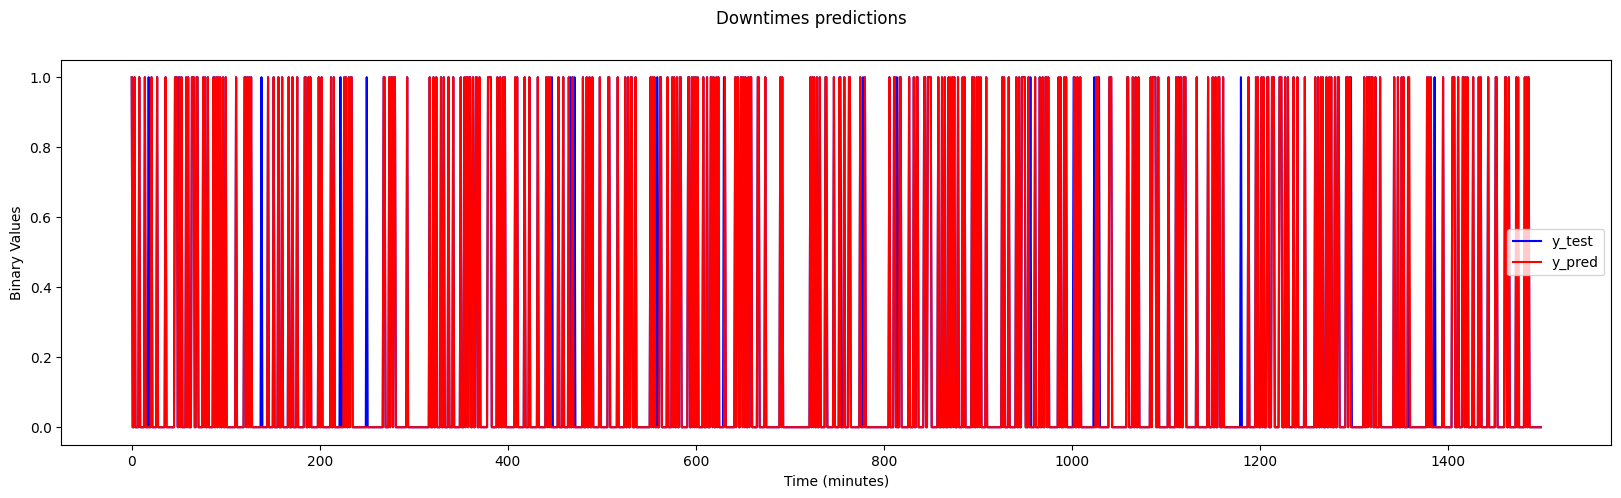

In [16]:
fig, ax = plt.subplots(figsize=(20,5))

# plot the first column on the first subplot
results['y_test'][:1500].plot(ax=ax, color='blue', label='y_test')
results['y_pred'][:1500].plot(ax=ax, color='red', label='y_pred')
ax.set_ylabel('Binary Values')

# add a legend and axis labels to the whole figure
fig.suptitle('Downtimes predictions')
plt.xlabel('Time (minutes)')
plt.legend()

# show the plot
plt.show()

# LSTM

In [2]:
df = pd.read_csv('./dataframes/data_preprocessed_seconds.csv')
df.head()

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
0,2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
1,2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
2,2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
3,2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
4,2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,NaN,NaN,NaN


In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.fillna(0, inplace=True)
df.set_index('DateTime', inplace=True)
data = df.copy()

In [4]:
tags = df.iloc[:,0:3].columns.tolist()
alarms = df.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df.columns}
df_minute = df.groupby(pd.Grouper(freq='1T')).agg(agg_dict)
data = df_minute.copy()

In [5]:
data.drop(columns=['alarm_11225', 'alarm_11231'], inplace=True)

In [6]:
numerical_cols = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
# categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231']
categorical_cols = ['downtime']

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [7]:
neg, pos = np.bincount(data['downtime'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
total, pos, 100 * pos / total))

Examples:
    Total: 525601
    Positive: 107584 (20.47% of total)



In [8]:
n = len(data)
train_df = data[0:int(n*0.8)]
val_df = data[int(n*0.8):int(n*0.9)]
test_df = data[int(n*0.9):]

<Axes: xlabel='DateTime'>

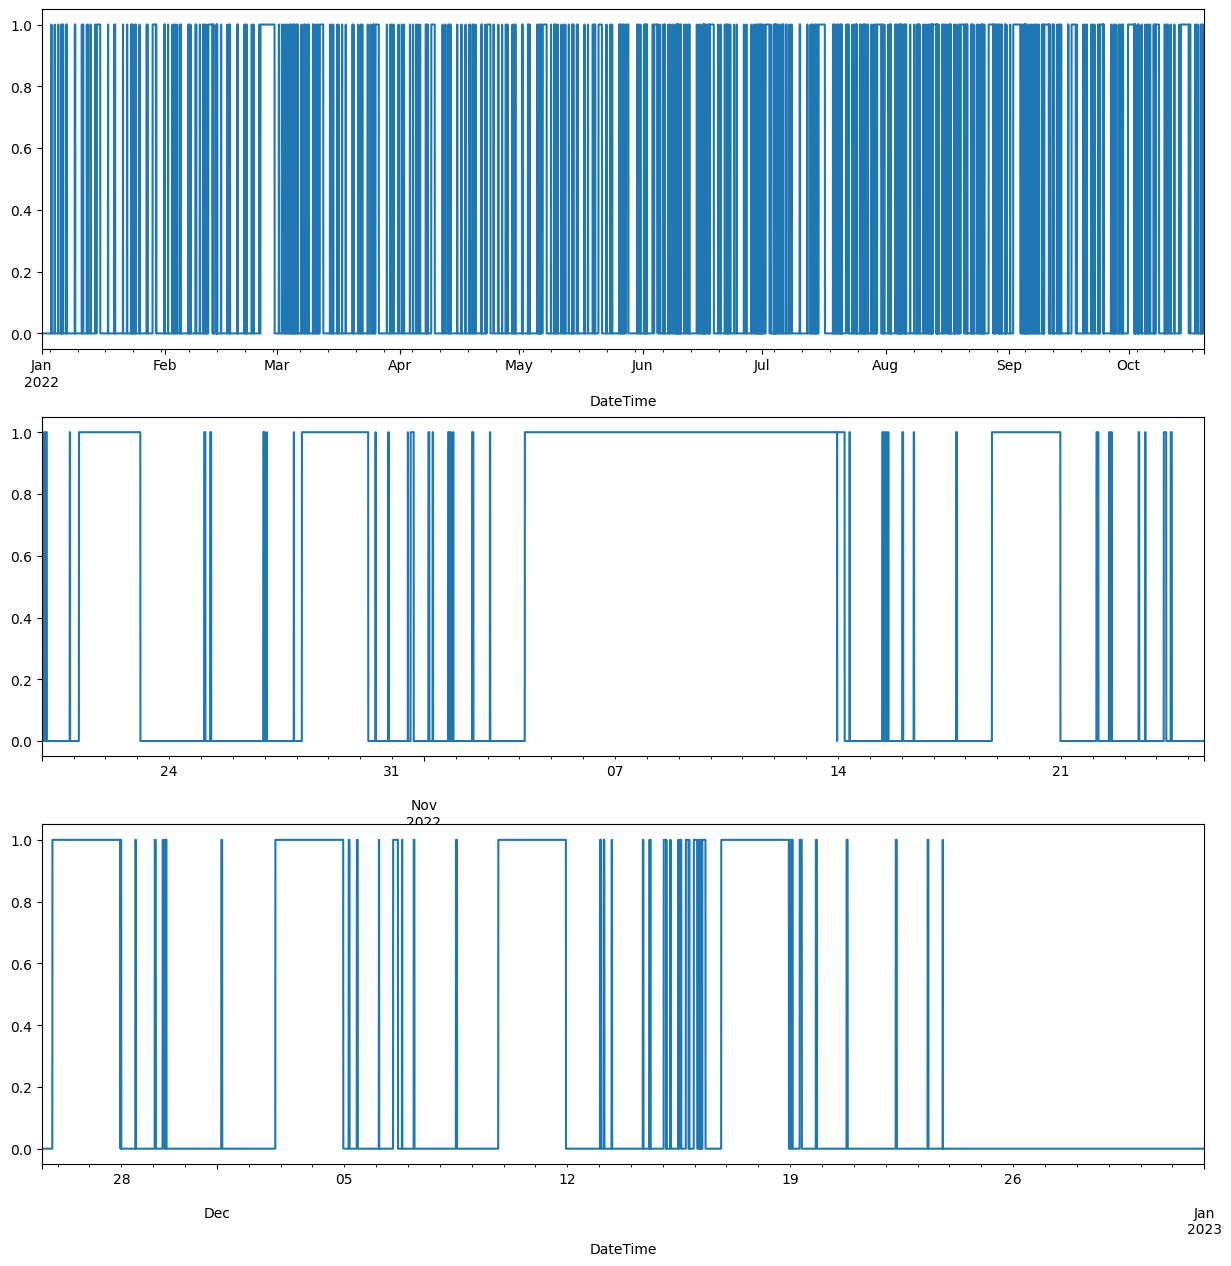

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
train_df['downtime'].plot(ax =ax1)
val_df['downtime'].plot(ax=ax2)
test_df['downtime'].plot(ax=ax3)

In [10]:
window_generator = WindowGenerator(input_width=15, label_width=1, 
                                   shift=5, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['downtime'])

In [11]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(train_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 15, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 15, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 15, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [12]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [13]:
model = Sequential([
    LSTM(32, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(1, activation='sigmoid')
])

In [38]:
import keras.backend as K

def custom_loss(y_true, y_pred):
    first_1_idx = None
    for i in range(K.int_shape(y_true)[1]):
        if K.any(K.equal(y_true[:,i], 1)):
            first_1_idx = i
            break
    if first_1_idx is None:
        return K.mean(K.binary_crossentropy(y_true, y_pred))
    else:
        y_true_relevant = y_true[:,first_1_idx:]
        y_pred_relevant = y_pred[:,first_1_idx:]
        for i in range(K.int_shape(y_true_relevant)[1]):
            if K.any(K.equal(y_true_relevant[:,i], 0)):
                y_pred_relevant[:,i] = 0
        return K.mean(K.binary_crossentropy(y_true_relevant, y_pred_relevant))



In [39]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.optimizers.Adam(),
#               metrics=[tf.metrics.BinaryAccuracy()])

model.compile(loss=custom_loss,
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.BinaryAccuracy()])

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [41]:
history = model.fit(train_ds, epochs=6, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/6


ValueError: in user code:

    File "c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\manda\AppData\Local\Temp\ipykernel_22944\1194759263.py", line 6, in custom_loss  *
        if K.any(K.equal(y_true[:,i], 1)):

    ValueError: 'first_1_idx' is None at the end of the else branch.


In [18]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds).round()
y_true = test_df['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

1641/1641 [==============================] - 20s 11ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     38306
           1       0.97      0.97      0.97     14186

    accuracy                           0.98     52492
   macro avg       0.98      0.98      0.98     52492
weighted avg       0.98      0.98      0.98     52492



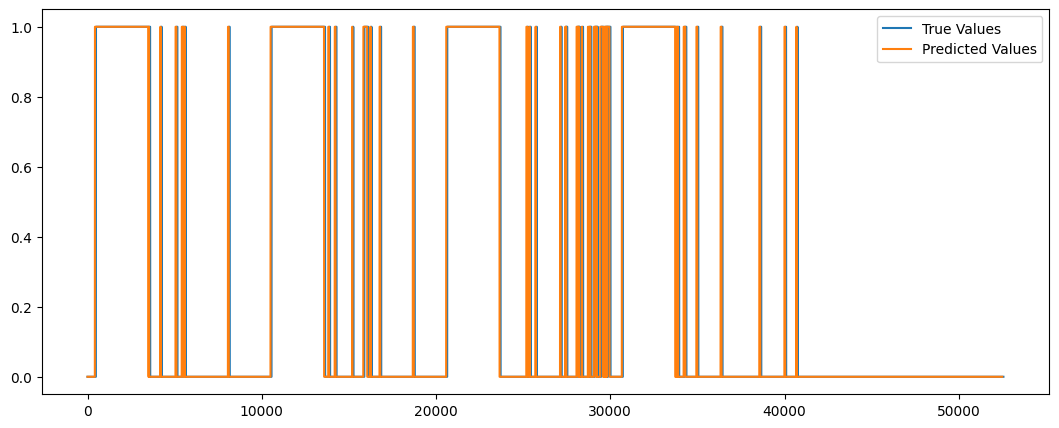

In [19]:
plt.figure(figsize=(13, 5))
plt.plot(np.array(test_df['downtime']), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.show()

In [20]:
df_2023 = pd.read_csv('./dataframes/data_2023.csv')

In [21]:
df_2023['DateTime'] = pd.to_datetime(df_2023['DateTime'])
df_2023.set_index('DateTime', inplace=True)

<Axes: xlabel='DateTime'>

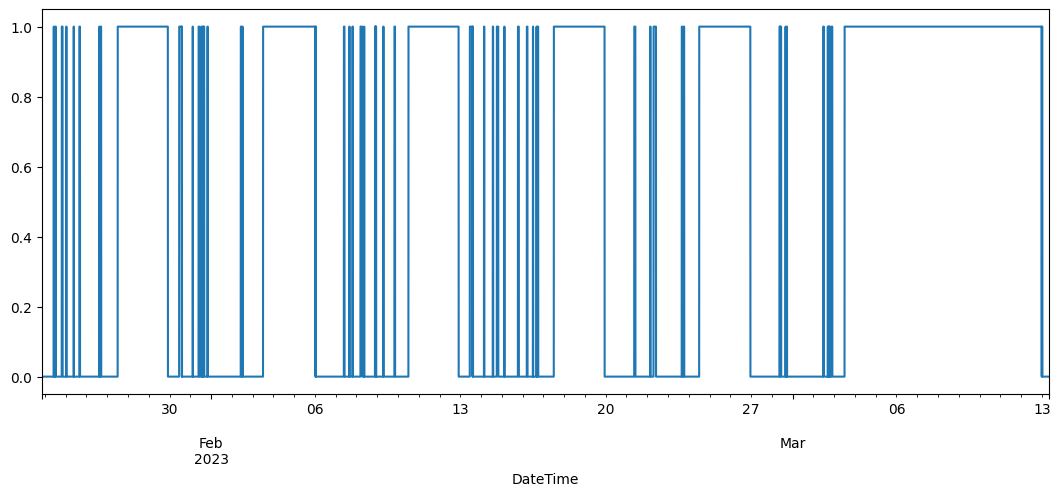

In [22]:
df_2023['downtime'].plot(figsize=(13, 5))

In [23]:
tags = df_2023.iloc[:,0:3].columns.tolist()
alarms = df_2023.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df_2023.columns}
df_minute = df_2023.groupby(pd.Grouper(freq='1T')).agg(agg_dict)
data = df_minute.copy()

<Axes: xlabel='DateTime'>

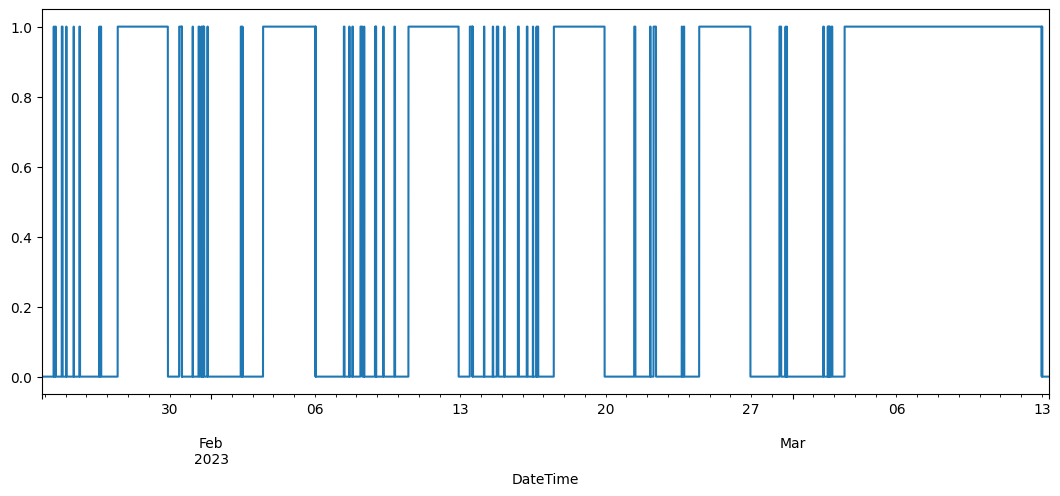

In [24]:
data['downtime'].plot(figsize=(13, 5))

In [25]:
test_ds2 = window_generator.make_dataset(data)

features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 60, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [26]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds2).round()
y_true = data['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

2181/2181 [==============================] - 32s 15ms/step
              precision    recall  f1-score   support

           0       0.99      0.44      0.61     36022
           1       0.62      0.99      0.77     33767

    accuracy                           0.71     69789
   macro avg       0.81      0.72      0.69     69789
weighted avg       0.81      0.71      0.68     69789



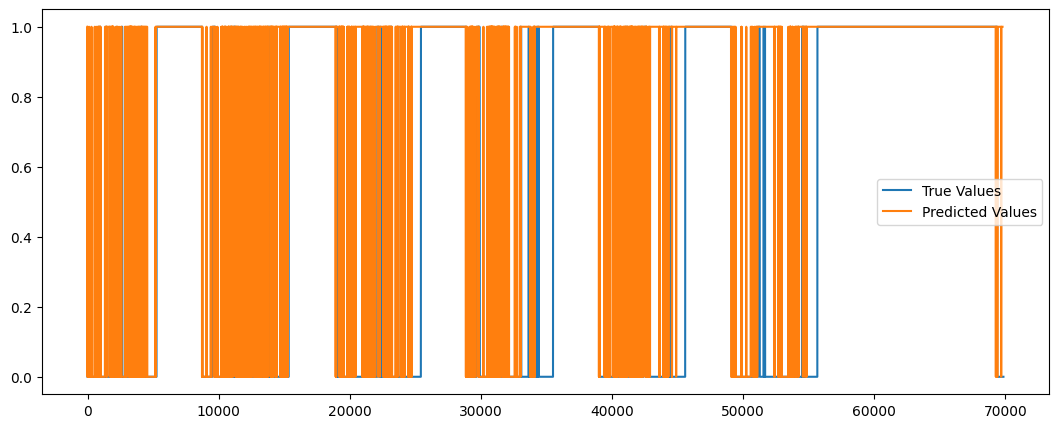

In [27]:
plt.figure(figsize=(13, 5))
plt.plot(np.array(data['downtime']), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.show()

In [28]:
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [29]:
test_ds2 = window_generator.make_dataset(data)

features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 60, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [30]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds2).round()
y_true = data['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

2181/2181 [==============================] - 25s 12ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     36022
           1       0.98      0.98      0.98     33767

    accuracy                           0.98     69789
   macro avg       0.98      0.98      0.98     69789
weighted avg       0.98      0.98      0.98     69789




Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [25/Apr/2023 14:45:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2023 14:45:14] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2023 14:45:14] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


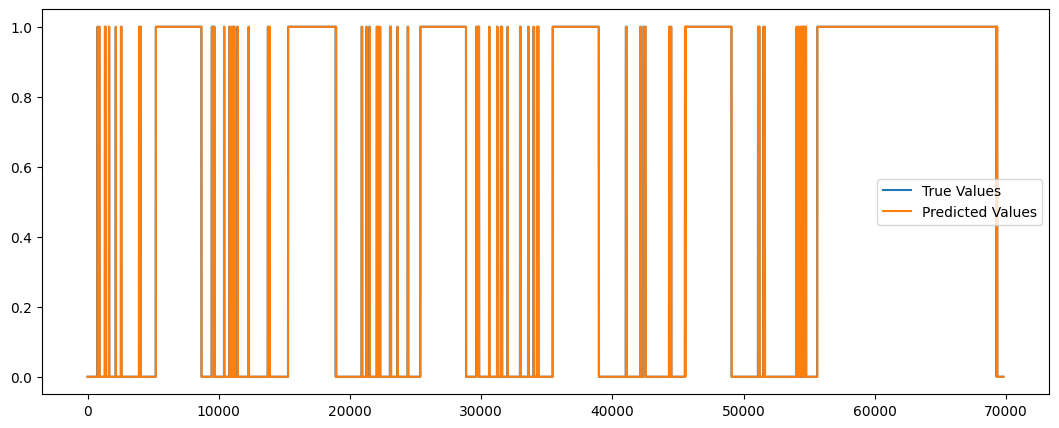

In [31]:
from mpld3 import plugins
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(y_true, label='True Values')
ax.plot(y_pred, label='Predicted Values')
ax.legend()

# Enable zooming using mpld3
plugins.connect(fig, plugins.Zoom())

# Show the plot
mpld3.show()

In [32]:
import numpy as np
from scipy.signal import correlate

y_pred_1d = y_pred.flatten()

corr = correlate(y_true, y_pred_1d)

# Find the lag with the maximum correlation
lag = np.argmax(corr) - len(y_true) + 1

print("Lag:", lag)

Lag: -10


# Downtime Trigger classification

## Data processing

In [2]:
df = pd.read_csv('./dataframes/data_preprocessed_seconds.csv')
df.head()

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
0,2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
1,2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
2,2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
3,2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
4,2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,NaN,NaN,NaN


In [3]:
df

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
0,2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
1,2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
2,2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
3,2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
4,2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
...,...,...,...,...,...,...,...
31535996,2022-12-31 23:59:56,-1.718033,-0.397858,-4.593460,NaN,NaN,NaN
31535997,2022-12-31 23:59:57,-1.718033,-0.397858,-4.593460,NaN,NaN,NaN
31535998,2022-12-31 23:59:58,-1.718033,-0.397858,-4.593460,NaN,NaN,NaN
31535999,2022-12-31 23:59:59,-1.718033,-0.397858,-4.593460,NaN,NaN,NaN


In [4]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.fillna(0, inplace=True)
df.set_index('DateTime', inplace=True)
df.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
DateTime,,,,,,
2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,0.0,0.0,0.0


In [5]:
df['trigger'] = (df['downtime'].diff() == 1).astype(int)
df.trigger.value_counts()

0    31535375
1         626
Name: trigger, dtype: int64

In [6]:
tags = df.iloc[:,0:3].columns.tolist()
alarms = df.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df.columns}

In [7]:
df_minute = df.groupby(pd.Grouper(freq='1T')).agg(agg_dict)

In [17]:
from mpld3 import plugins
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(data['GLA3_CO_258_024'][:44000], label='024')
ax.plot(data['GLA3_CO_258_028'][:44000], label='028')
ax.plot(data['GLA3_CO_258_032'][:44000], label='032')
ax.plot(data['downtime'][:44000], label='DOWNTIME')

ax.legend()

# Enable zooming using mpld3
plugins.connect(fig, plugins.Zoom())

# Show the plot
mpld3.show()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


In [9]:
df_minute.isna().sum()

GLA3_CO_258_024    0
GLA3_CO_258_028    0
GLA3_CO_258_032    0
downtime           0
alarm_11225        0
alarm_11231        0
trigger            0
dtype: int64

In [10]:
dataframe = df_minute[~((df_minute['downtime'] == 1) & (df_minute['trigger'] == 0))]

In [11]:
dataframe.trigger.value_counts()

0    418017
1       626
Name: trigger, dtype: int64

In [12]:
dataframe.isna().sum()

GLA3_CO_258_024    0
GLA3_CO_258_028    0
GLA3_CO_258_032    0
downtime           0
alarm_11225        0
alarm_11231        0
trigger            0
dtype: int64

In [13]:
df = dataframe.copy()

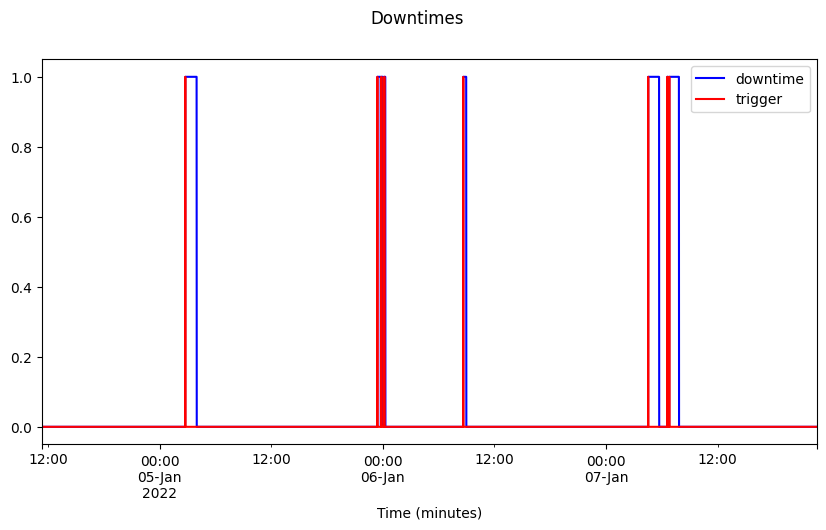

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
df_minute['downtime'][5000:10000].plot(ax =ax, color='blue', label='downtime')
df_minute['trigger'][5000:10000].plot(ax=ax, color='red', label='trigger')


# add a legend and axis labels to the whole figure
fig.suptitle('Downtimes')
plt.xlabel('Time (minutes)')
plt.legend()

# show the plot
plt.show()

In [15]:
numerical_cols = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231', 'trigger']

In [12]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

In [16]:
data = dataframe.copy()

In [16]:
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

## ML Model classifier

In [22]:
X = data[['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']].values
y = data['trigger'].values

In [23]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231,trigger
DateTime,,,,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0,0,0,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0,0,0,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0,0,0,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0,0,0,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0,0,0,0
...,...,...,...,...,...,...,...
2022-12-31 23:56:00,0.448540,0.721742,-0.158425,0,0,0,0
2022-12-31 23:57:00,0.449917,0.716949,-0.154997,0,0,0,0
2022-12-31 23:58:00,0.451658,0.730301,-0.161457,0,0,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [25]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [27]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_overesampled, y_overresampled = oversample.fit_resample(X, y)

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [26]:
print(f'X shape is {X_train.shape[0]} and after resampling {X_resampled.shape[0]}')


X shape is 293050 and after resampling 848


In [35]:
def trainingModel(model):
    model = model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [36]:
trainingModel(DecisionTreeClassifier())

Accuracy: 0.6230283534910385


In [37]:
model = DecisionTreeClassifier()
model.fit(X_resampled, y_resampled)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['downtime','no-downtime']))

              precision    recall  f1-score   support

    downtime       1.00      0.62      0.77    125391
 no-downtime       0.00      0.67      0.01       202

    accuracy                           0.62    125593
   macro avg       0.50      0.65      0.39    125593
weighted avg       1.00      0.62      0.76    125593



In [34]:
data.trigger.value_counts()

0    418017
1       626
Name: trigger, dtype: int64

## LSTM forecaster

In [18]:
data_bck = df.copy()

In [20]:
df.drop(columns=['downtime', 'alarm_11225', 'alarm_11231'], inplace=True)

In [21]:
data = df

In [22]:
data.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,trigger
DateTime,,,,
2022-01-01 00:00:00,-73.845002,0.195913,-2.611098,0
2022-01-01 00:01:00,-73.752172,0.093435,-2.634310,0
2022-01-01 00:02:00,-74.037905,0.159144,-2.581563,0
2022-01-01 00:03:00,-73.834455,0.104590,-2.598743,0
2022-01-01 00:04:00,-73.920357,0.081378,-2.568001,0


In [23]:
data.rename(columns={'trigger':'downtime'}, inplace=True)

In [25]:
data.dtypes

GLA3_CO_258_024    float64
GLA3_CO_258_028    float64
GLA3_CO_258_032    float64
downtime             int32
dtype: object

In [27]:

from imblearn.over_sampling import SMOTENC


# Initialize the SMOTENC algorithm
smote_nc = SMOTENC(categorical_features=alarms, random_state=42)

# Generate synthetic examples for the minority class
X_resampled, y_resampled = smote_nc.fit_resample(data.drop("downtime", axis=1), data["downtime"])

# Create a new balanced data set with the original and synthetic examples
data_resampled = pd.concat([pd.DataFrame(X_resampled, columns=data.drop("downtime", axis=1).columns), pd.Series(y_resampled, name="downtime")], axis=1)

# Shuffle the final data set
data_resampled = data_resampled.sample(frac=1)

# Convert the categorical features to one-hot encoding
data_resampled = pd.get_dummies(data_resampled, columns=alarms)

# Convert the time series data to a 3D array for LSTM input
num_features = data_resampled.shape[1] - 1
num_timesteps = len(data_resampled) // num_features
X = np.array(data_resampled.drop("downtime", axis=1)).reshape((num_timesteps, num_features, -1))
y = np.array(data_resampled["downtime"])


c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\imblearn\over_sampling\_smote\base.py:552: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  [cat not in np.arange(self.n_features_) for cat in categorical_features]


ValueError: Some of the categorical indices are out of range. Indices should be between 0 and 2

In [22]:
n = len(data)
train_df = data[0:int(n*0.8)]
val_df = data[int(n*0.8):int(n*0.9)]
test_df = data[int(n*0.9):]

<Axes: xlabel='DateTime'>

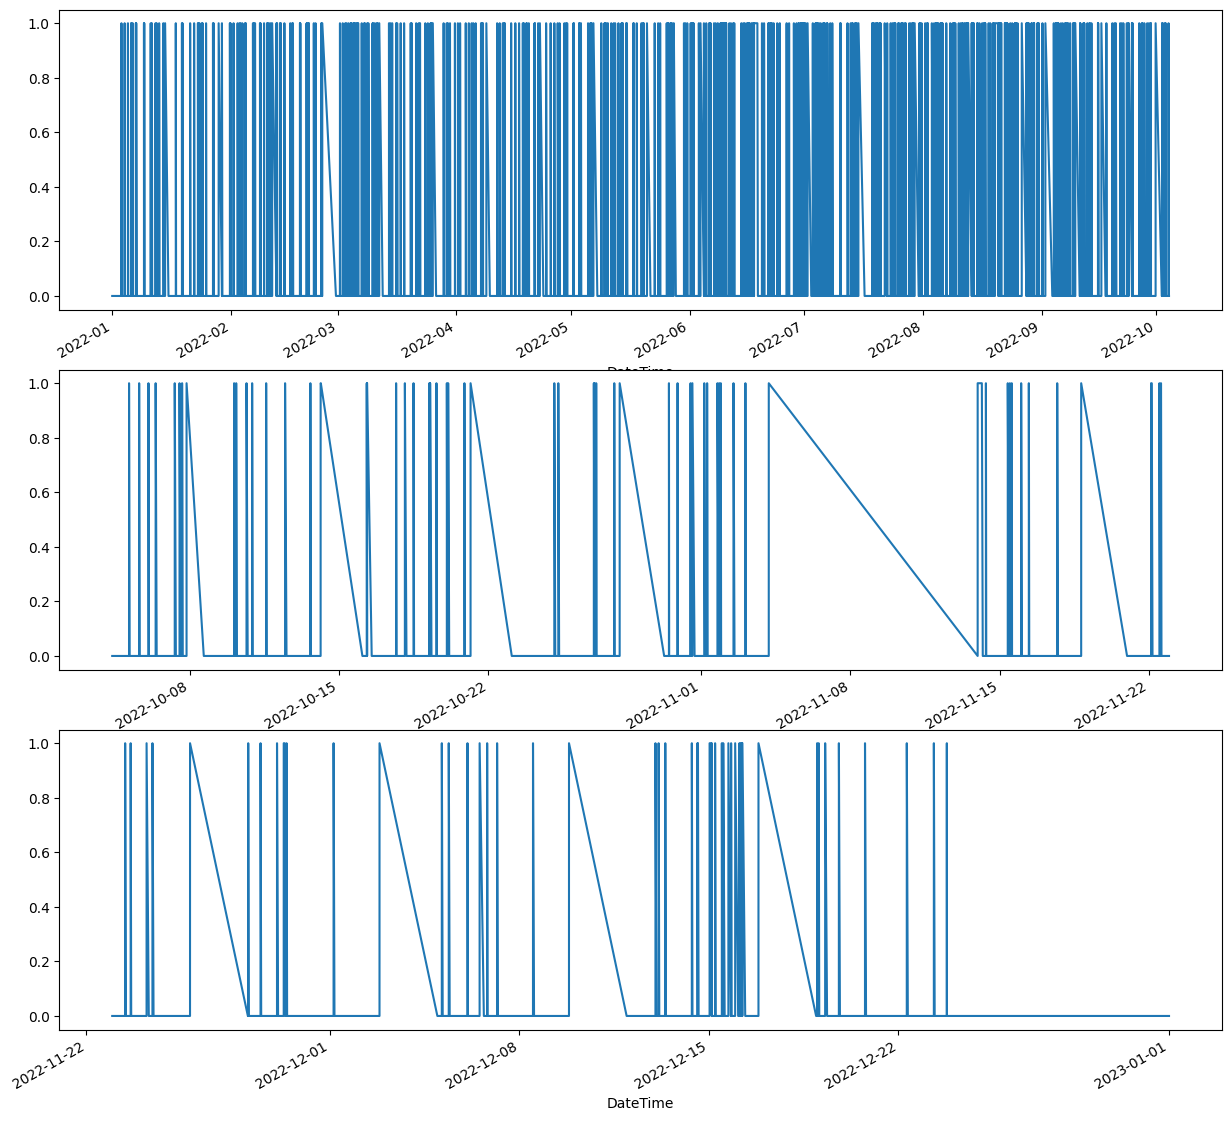

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
train_df['downtime'].plot(ax =ax1)
val_df['downtime'].plot(ax=ax2)
test_df['downtime'].plot(ax=ax3)

In [37]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime
DateTime,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0
...,...,...,...,...
2022-12-31 23:56:00,0.448540,0.721742,-0.158425,0
2022-12-31 23:57:00,0.449917,0.716949,-0.154997,0
2022-12-31 23:58:00,0.451658,0.730301,-0.161457,0


In [38]:
from imblearn.over_sampling import SMOTENC

smote_nc = SMOTENC(categorical_features=categorical_cols, random_state=42)


X_resampled, y_resampled = smote_nc.fit_resample(df.drop("downtime", axis=1), df["downtime"])

# Create a new balanced data set with the original and synthetic examples
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=data.drop("downtime", axis=1).columns), pd.Series(y_resampled, name="downtime")], axis=1)

# Shuffle the final data set
df_resampled = df_resampled.sample(frac=1)

# Convert the categorical features to one-hot encoding
df_resampled = pd.get_dummies(df_resampled, columns=categorical_cols)

# Convert the time series data to a 3D array for LSTM input
num_features = df_resampled.shape[1] - 1
num_timesteps = len(df_resampled) // num_features
X = np.array(df_resampled.drop("downtime", axis=1)).reshape((num_timesteps, num_features, -1))
y = np.array(df_resampled["downtime"])

c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\imblearn\over_sampling\_smote\base.py:552: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  [cat not in np.arange(self.n_features_) for cat in categorical_features]


ValueError: Some of the categorical indices are out of range. Indices should be between 0 and 5

In [24]:
window_generator = WindowGenerator(input_width=5, label_width=1, 
                                   shift=5, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['downtime'])

In [25]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(train_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [26]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [27]:
model = Sequential([
    LSTM(32, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(1, activation='sigmoid')
])

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.BinaryAccuracy()])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [30]:
history = model.fit(train_ds, epochs=6, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/6
10466/10466 [==============================] - 88s 8ms/step - loss: 0.0144 - binary_accuracy: 0.9983 - val_loss: 0.0115 - val_binary_accuracy: 0.9985
Epoch 2/6
10466/10466 [==============================] - 99s 9ms/step - loss: 0.0115 - binary_accuracy: 0.9985 - val_loss: 0.0115 - val_binary_accuracy: 0.9985
Epoch 3/6
10466/10466 [==============================] - 86s 8ms/step - loss: 0.0115 - binary_accuracy: 0.9985 - val_loss: 0.0115 - val_binary_accuracy: 0.9985
Epoch 4/6
10466/10466 [==============================] - 104s 10ms/step - loss: 0.0114 - binary_accuracy: 0.9985 - val_loss: 0.0115 - val_binary_accuracy: 0.9985
Epoch 5/6
10466/10466 [==============================] - 108s 10ms/step - loss: 0.0114 - binary_accuracy: 0.9985 - val_loss: 0.0115 - val_binary_accuracy: 0.9985
Epoch 6/6
10466/10466 [==============================] - 97s 9ms/step - loss: 0.0114 - binary_accuracy: 0.9985 - val_loss: 0.0115 - val_binary_accuracy: 0.9985


In [31]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds).round()
y_true = test_df['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

1308/1308 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41806
           1       0.00      0.00      0.00        50

    accuracy                           1.00     41856
   macro avg       0.50      0.50      0.50     41856
weighted avg       1.00      1.00      1.00     41856



c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(np.array(test_df['downtime']), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.show()

# ML with alarms

In [12]:
data = pd.read_csv('./dataframes/pivot_alarms_cleaned.csv')

In [13]:
data.head()

,DateTime,2421,2445,4203,6280,6336,7167,9218,9219,9495,...,22019,22020,22021,22022,22024,22040,22045,24324,35002,49317
0,2022-01-03 09:53:36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2022-01-03 10:31:02,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-03 10:55:39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2022-01-03 10:59:57,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-03 11:23:14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

In [15]:
df_minute = data.groupby(pd.Grouper(freq='1T')).agg('max')

In [16]:
print(f"seconds {data.shape} and after {df_minute.shape}")

seconds (81110, 30) and after (566766, 30)
